# Chapter 9 - Newton's method


In this chapter, we will implement Newton's method. For a general minimization problem 
$$
\min_{\mathbf{x} \in \mathbb{R}^n} f(\mathbf{x}),
$$
Newton's method gives the algorithm
$$
\left\{
\begin{eqnarray}
&&\mathbf{d}_k &=& -F^{-1}(\mathbf{x}_k)\nabla f(\mathbf{x}_k), \\
&&\mathbf{x}_{k+1} &=& \mathbf{x}_k + \mathbf{d}_k,
\end{eqnarray}\right.
$$
where $F(\mathbf{x})$ is the Hessian of $f$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# You are to implement this function
from gradientMethods.newton import solve

## Rosenbrock's Function

We will first consider the so-called Rosenbrock's function (see Exercise 9.4 in the book), given by
$$
f(\mathbf{x}) = 100(x_2-x_1^2)^2 + (1-x_1)^2.
$$

The objective is to minimize the function over $\mathbb{R}^2$.


### Implementation

We will start by computing the gradient and Hessian of Rosenbrock's function

In [2]:
def grad_rosenbrock(x):
    x1, x2 = x #Unpack values
    return np.array([2*x1*(1-200*(x2-x1**2))-2, 200*(x2-x1**2)]) 

def hessian_rosenbrock(x):
    x1, x2 = x #Unpack values
    return np.array([[2*(1-200*(x2-x1**2))+800*x1**2, -400*x1], [-400*x1, 200]])

We are now in a position to call Newton's method (as long as this function is implemented)

In [12]:
#Let go ahead and call Newton's method
xks = solve(grad_rosenbrock, hessian_rosenbrock, x_init=np.array([-1,3]))

#We store the x1 and x2-coordinates in seperate variables
x1 = [z[0] for z in xks]
x2 = [z[1] for z in xks]

Finally, we can plot the iterative method and compare to the contour plot of Rosenbrock's function.

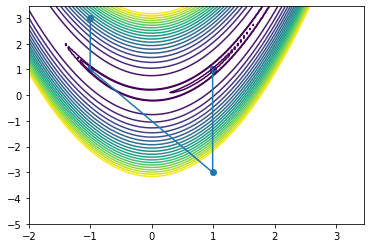

In [42]:
X = np.arange(-2,3.5,0.05)
Y = np.arange(-5,3.5,0.05)
X, Y = np.meshgrid(X,Y)

def rosenbrock(x):
    x1, x2 = x
    return 100*(x2-x1**2)**2 + (1-x1)**2

Z = np.array( [rosenbrock(z) for z in zip (np.ravel(X), np.ravel(Y))]).reshape(X.shape)

fig, ax = plt.subplots()

ax.contour(X,Y,Z, levels=np.concatenate([np.linspace(.5,5,2), np.linspace(6,1000,20)]))
ax.scatter(x1,x2)
ax.plot(x1,x2)

## Nonlinear least squares

We will demonstrate how Newton's method can be used to solve a nonlinear regression problem. In general, if we have observations $\{(t_i, y_i)\}$, we want to fit a model
$$
y = A\sin(\omega t + \rho).
$$
To obtain the parameters $\mathbf{x} = [A, \omega, \rho]^T$, we aim to minimize
$$
\min_\mathbf{x} \Sigma_{i=1}^n (y_i - A\sin(\omega t_i + \rho))^2.
$$
This is a nonlinear least squares problem.

In [11]:
# You are now to implement this function
from gradientMethods.newton import solve_nls

### Generate data

We will start by generating the data in order to get an idea of what this looks lik

In [2]:
a = 0
b = 3*np.pi
n = 30

A = 2
omega = 1
rho = np.pi/4

t = np.linspace(a,b,n)
y = A*np.sin(omega*t + rho) + 0.1*np.random.randn(n) #The second term on the rhs is noise

and plot the data to get an idea of how this looks like

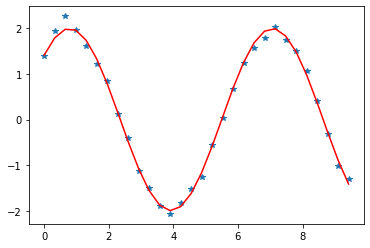

In [3]:
plt.plot(t,y,'*')
plt.plot(t,A*np.sin(omega*t+rho),'r-')
plt.show()

## Newton's method

We will compute the gradient and Hessian of $f(\mathbf{x};t_i)$ in order to derive Newton's method. To do this, we will follow the steps of Example 9.2 (p. 169-171) in the textbook.

### Gradient

Let us define
$$
f(\mathbf{x}) = \sum_{i=1}^n (y_i - A\sin(\omega t_i + \rho))^2,
$$
and we write the residual
$$
r_i(\mathbf{x}) = y_i - A\sin(\omega t_i + \rho).
$$
Combining the two expressions above, we get the compact expression
$$
f(\mathbf{x}) = \sum_{i=1}^n r_i^2(\mathbf{x}).
$$
Consequently,
$$
(\nabla f(\mathbf{x}))_j = \frac{\partial f}{\partial x_j}(\mathbf{x}) = 2\sum_{i=1}^n r_i(\mathbf{x})\frac{\partial r_i}{\partial x_j}(\mathbf{x})
$$
If we denote the Jacobian of $\mathbf{r}$ as
$$
J(\mathbf{x}) = \begin{bmatrix} \frac{\partial r_1}{\partial x_1}(\mathbf{x}) & \frac{\partial r_1}{\partial x_2}(\mathbf{x}) & \frac{\partial r_1}{\partial x_3}(\mathbf{x}) \\ \vdots & \vdots & \vdots \\ \frac{\partial r_n}{\partial x_1}(\mathbf{x}) & \frac{\partial r_n}{\partial x_2}(\mathbf{x}) & \frac{\partial r_n}{\partial x_3}(\mathbf{x}) \end{bmatrix}.
$$
Hence, we can write the gradient of $f$ as
$$
\nabla f(\mathbf{x}) = 2J(\mathbf{x})^T\mathbf{r}(\mathbf{x})
$$

#### Computing the partial derivatives

With $x_1 = A$, $x_2 = \omega$ and $x_3 = \rho$, we get
$$
\frac{\partial r_i}{\partial x_1} = -\sin(\omega t_i + \rho)
$$
$$
\frac{\partial r_i}{\partial x_2} = -At_i\cos(\omega t_i + \rho)
$$
$$
\frac{\partial r_i}{\partial x_3} = -A\cos(\omega t_i + \rho)
$$

In [4]:
def grad_f(x,t,y):
    A, omega, rho = x #Unpack values
    r = y - A*np.sin(omega*t+rho)
    Jx = np.stack(((-np.sin(omega*t+rho)), (-A*t*np.cos(omega*t+rho)), (-A*np.cos(omega*t+rho))))
    
    return Jx, 2*Jx.dot(r) #We return both the Jacobian of r and the gradient of f

### Hessian

We now compute the Hessian of $f$. We obtain
$$
\begin{eqnarray}
  \frac{\partial^2 f}{\partial x_k \partial x_j}(\mathbf{x}) &=& \frac{\partial}{\partial x_k}\left(\frac{\partial f}{\partial x_j}(\mathbf{x})\right) \\ &=& \frac{\partial}{\partial x_k}\left(2\sum_{i=1}^n r_i(\mathbf{x})\frac{\partial r_i}{\partial x_j}(\mathbf{x})\right) \\ &=& 2 \sum_{i=1}^n \left(\frac{\partial r_i}{\partial x_k}(\mathbf{x})\frac{\partial r_i}{\partial x_j}(\mathbf{x}) + r_i(\mathbf{x})\frac{\partial^2 r_i}{\partial x_k\partial x_j}(\mathbf{x})\right).
\end{eqnarray}
$$
If we define the matrix $S(\mathbf{x})$ as the matrix with $(k,j)$-component
$$
\sum_{i=1}^n r_i(\mathbf{x}\frac{\partial^2 r_i}{\partial x_k \partial x_j} (\mathbf{x}),
$$
the Hessian of $f$ can be expressed as
$$
D^2 f(\mathbf{x}) = 2(J(\mathbf{x})^T J(\mathbf{x}) + S(\mathbf{x})).
$$

#### Computing second-order derivatives

$$
\frac{\partial^2 r_i}{\partial x_1^2} = 0, \quad \frac{\partial^2 r_i}{\partial x_2\partial x_1} = -t_i\cos(\omega t_i + \rho), \quad \frac{\partial^2 r_i}{\partial x_3\partial x_1} = -\cos(\omega t_i + \rho), 
$$
$$
\frac{\partial^2 r_i}{\partial x_1\partial x_2} = -t_i\cos(\omega t_i + \rho), \quad \frac{\partial^2 r_i}{\partial x_2^2} = At_i^2\sin(\omega t_i + \rho), \quad \frac{\partial^2 r_i}{\partial x_3\partial x_2} = At_i\sin(\omega t_i + \rho), 
$$
$$
\frac{\partial^2 r_i}{\partial x_1\partial x_3} = -\cos(\omega t_i + \rho), \quad \frac{\partial^2 r_i}{\partial x_2\partial x_3} = At_i\sin(\omega t_i + \rho), \quad \frac{\partial^2 r_i}{\partial x_3^2} = A\sin(\omega t_i + \rho), 
$$

In [5]:
def hessian_f(x,t,y,Jx):
    A, omega, rho = x #Unpack values
    r = y - A*np.sin(omega*t+rho)
    
    S = np.zeros((3,3))
    S[0,0] = 0
    S[0,1] = np.sum(r*(-t*np.cos(omega*t+rho)))
    S[0,2] = np.sum(r*(-np.cos(omega*t+rho)))
    S[1,0] = S[0,1]
    S[1,1] = np.sum(r*A*t**2*np.sin(omega*t+rho))
    S[1,2] = np.sum(r*A*t*np.sin(omega*t+rho))
    S[2,0] = S[0,2]
    S[2,1] = S[1,2]
    S[2,2] = np.sum(r*A*np.sin(omega*t+rho))
    
    return 2*(Jx.dot(np.transpose(Jx))+S)

In [6]:
# Call Newton's method for nonlinear least squares
xks = solve_nls(grad_f, hessian_f, np.stack((t,y)), x_init=np.ones(3))

# Extract final iteration
x_opt = xks[-1]

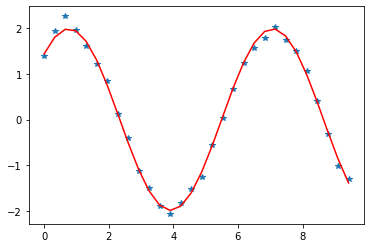

In [7]:
plt.plot(t,y,'*')
plt.plot(t,x_opt[0]*np.sin(x_opt[1]*t+x_opt[2]),'r-')
plt.show()